In [2]:
import numpy as np
import matplotlib.pyplot as plt

import os

import matplotlib as mpl
import matplotlib.patches as mpatches
from matplotlib import rc

direction='in'
mpl.rcParams.update({
'font.family' : 'Arial',
'mathtext.fontset' : 'cm',
'xtick.direction' : f'{direction}' ,
'ytick.direction' : f'{direction}' ,
'xtick.labelsize' : 17.5 ,
'xtick.top' : True ,
'xtick.major.width' : 1.5,
'xtick.major.size' : 6,
'ytick.labelsize' : 17.5 ,
'ytick.right' : True ,
'ytick.major.width' : 1.5,
'ytick.major.size' : 6,
'axes.labelsize' : 18,
'legend.frameon' : False,
'legend.fontsize' : 13,
'legend.handlelength' : 2,
'savefig.dpi' : 600, 
'savefig.bbox' : 'tight',
'axes.linewidth' : 1.5,
})
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import seaborn as sns

from scipy import stats

print(plt.rcParams['font.family'])

['Arial']


In [3]:
def is_non_zero_file(fpath, verb=False, n=10, filelen = 11):
    result = os.path.isfile(fpath) and os.path.getsize(fpath) > 0
    if not result:
        if verb: print('No', fpath); 
    else:
        _ = np.loadtxt(fpath, dtype='float64')
        result = result and _.reshape(-1).shape[0]//n > filelen
        if not result: 
            if verb: print('No', fpath, _.shape); 
    return result

def loadtxt(filename):
    if not is_non_zero_file(filename, False, n=1, filelen=0): return np.array([np.nan])
    else: return np.loadtxt(filename, dtype='float64')


def near(arr, n=10):
    arr = np.array(arr)
    sum_arr = np.zeros(arr.shape[0]-n)
    for i in range(n):
        sum_arr += arr[i:arr.shape[0]-n+i]
    return sum_arr

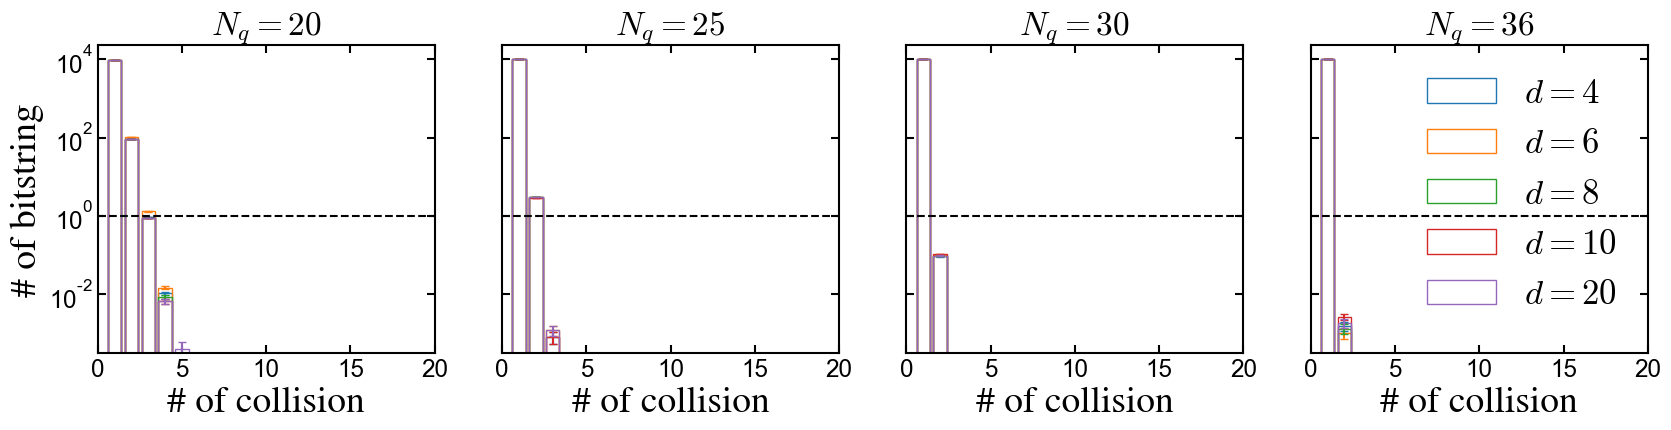

In [3]:
prefix = 'Data_out/g2_saved_models_rqc/'
colors = sns.color_palette()

    
fig, ax = plt.subplots(1,4,figsize=(20,4), sharey='row')
for i,nr, nc in [(0,4,5), (1,5,5), (2,5,6), (3,6,6)]:
    for j,d1 in enumerate([4,6,8,10,20]):
        data = np.load(f'{prefix}collision_{nr*nc}_{d1}.npz')
        barlist = ax[i].bar(np.arange(data['s'].shape[1])+1, data['s'].mean(axis=0), \
                            color='none', edgecolor=colors[j], label=fr'$d={d1}$')
        ax[i].errorbar(np.arange(data['s'].shape[1])+1, data['s'].mean(axis=0), \
                     yerr=data['s'].std(axis=0)/np.sqrt(data['n'][2]), \
                     fmt='.', ms=0, c=colors[j], capsize=3)
    ax[i].set_xlim(0,20)
    ax[i].set_yscale('log')
    ax[i].axhline(1, ls='--', c='k')
    ax[i].set_xlabel('# of collision', fontsize=27, font='STIXGeneral')
    ax[i].set_title(fr'$N_q={nr*nc}$', fontsize=24)
ax[0].set_ylabel('# of bitstring', fontsize=27, font='STIXGeneral')
ax[-1].legend(fontsize=25)
# plt.savefig('fig_sup_D_collision.png', dpi=300)

In [4]:
def hyp_study(param_name, params):
    N = 10000
    dh = 16
    nh = 4
    n_c = 16
    fig, ax = plt.subplots(1,len(params),figsize=(len(params)*5,4), sharey='row')
    mn = 'cm1_A2'

    for i, param in enumerate(params):
        if param_name == 'N': N = param
        N_mini = N//5
        if param_name == 'N_{mini}': N_mini = param
        elif param_name == 'd_h': dh = param
        elif param_name == 'n_h': nh = param
        elif param_name == 'n_c': n_c = param
        run_avg = []
        for run in [0,1,2,3,4,5,6,7,8]:
            n = 5
            filename = 'Data_out/g2_saved_models_rqc/'+\
                f'{mn}_p0_{5}x{5}_{8}_vs20_run_{run}/'+\
                f'log_{5}x{5}_F_p0_{8}vs20-{mn[:-3]}_set{N}_h{dh}nh{nh}_ch{n_c}ker2st1_#miniset{N//N_mini}.txt'
            if not is_non_zero_file(filename, False, filelen = 20): continue
            _,_,_,_,ac_vl,ac_ts,_,_,_,_ = np.loadtxt(filename, dtype='float64', unpack=True)
            ac_ts_max = ac_ts[np.argsort(near(ac_vl,n=n))[-1]:np.argsort(near(ac_vl,n=n))[-1]+n].mean()
            ac_vl_max = ac_vl[np.argsort(near(ac_ts,n=n))[-1]:np.argsort(near(ac_ts,n=n))[-1]+n].mean()
            if ac_ts_max > ac_vl_max: run_avg.append(ac_ts_max)
            else: run_avg.append(ac_vl_max)
            ax[i].plot(ac_ts*100, c=color[run], label=f'run={run}')
            ax[i].axvspan(np.argsort(near(ac_ts,n=n))[-1], \
                          np.argsort(near(ac_ts,n=n))[-1]+n, fc=color[run], alpha=.2)

        ax[i].set_ylim(45, 70)
        ax[i].set_title(fr'${param_name}$ = {param}', fontsize=18)
        ax[i].set_xlabel(f'Epoch', fontsize=18)
        ax[i].set_ylabel(f'Accuracy (%)', fontsize=18)
        ax[i].legend()
        ax[i].set_xlim(0,400)
        ax[i].axhline(50, c='k', ls='--')
        with np.printoptions(formatter={'float': '{:.3f}'.format}):
            print(f'{np.array(run_avg).mean()*100:.3f} +- {np.array(run_avg).std()*100/2:.3f}', \
                  np.array(run_avg)*100)
    plt.show()

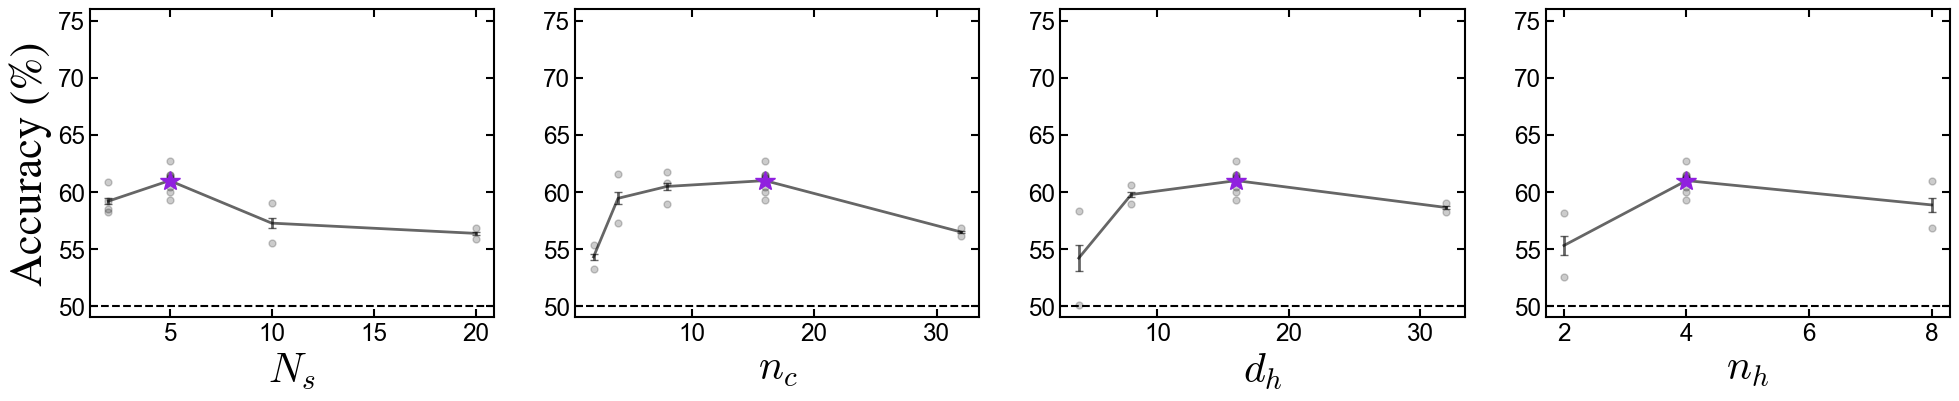

In [5]:
def hyp_study_param(ax, param_name, params, choice, first=False):
    N = 10000
    N_s = 5
    dh = 16
    nh = 4
    n_c = 16
    mn = 'cm1_A2'
    ac_param = np.zeros((len(params), 8)); ac_param[:] = np.nan
    for i, param in enumerate(params):
        if param_name == 'N': N = param
        if param_name == 'N_{s}': N_s = param
        elif param_name == 'd_h': dh = param
        elif param_name == 'n_h': nh = param
        elif param_name == 'n_c': n_c = param
        for run in [0,1,2,3,4,5,6,7]:
            n = 5
            filename = 'Data_out/g2_saved_models_rqc/'+\
                f'{mn}_p0_{5}x{5}_{8}_vs20_run_{run}/'+\
                f'log_{5}x{5}_F_p0_{8}vs20-{mn[:-3]}_set{N}_h{dh}nh{nh}_ch{n_c}ker2st1_#miniset{N_s}.txt'
            if not is_non_zero_file(filename, False, filelen = 20): continue
            _,_,_,_,ac_vl,ac_ts,_,_,_,_ = np.loadtxt(filename, dtype='float64', unpack=True)
            ac_vl, ac_ts = ac_vl[:400]*100, ac_ts[:400]*100
            ac_ts_max = ac_ts[np.argsort(near(ac_vl,n=n))[-1]:np.argsort(near(ac_vl,n=n))[-1]+n].mean()
            ac_vl_max = ac_vl[np.argsort(near(ac_ts,n=n))[-1]:np.argsort(near(ac_ts,n=n))[-1]+n].mean()
            if ac_ts_max > ac_vl_max: ac_param[i, run] = ac_ts_max
            else: ac_param[i, run] = ac_vl_max
        ax.plot(np.ones(8)*param, ac_param[i], 'ko', ms=5, alpha=.2)
    ax.errorbar(params, np.nanmean(ac_param, axis=1), \
                yerr=np.nanstd(ac_param, axis=1)/np.sqrt(np.count_nonzero(~np.isnan(ac_param))), \
                capsize=3, c='k', lw=2, alpha=.6)
    ax.plot(choice, np.nanmean(ac_param, axis=1)[params.index(choice)], '*', ms=15, c='#9020DF', zorder=10)
    ax.set_ylim(49, 76)
    ax.axhline(50, c='k', ls='--')
    ax.set_xlabel(fr'${param_name}$', fontsize=30)
    if first: ax.set_ylabel(f'Accuracy (%)', fontsize=32, font='STIXGeneral')

fig, ax = plt.subplots(1,4, figsize=(24, 4))
hyp_study_param(ax[1], 'n_c', [2,4,8,16,32], 16)
hyp_study_param(ax[2], 'd_h', [4,8,16,32], 16)
hyp_study_param(ax[3], 'n_h', [2,4,8], 4)
hyp_study_param(ax[0], 'N_{s}', [2,5,10,20], 5, first=True)
# hyp_study_param(ax[0], 'N', [80, 400, 2000, 10000], 10000, first=True)

# plt.savefig('fig_sup_D_hyp.png', dpi=300)

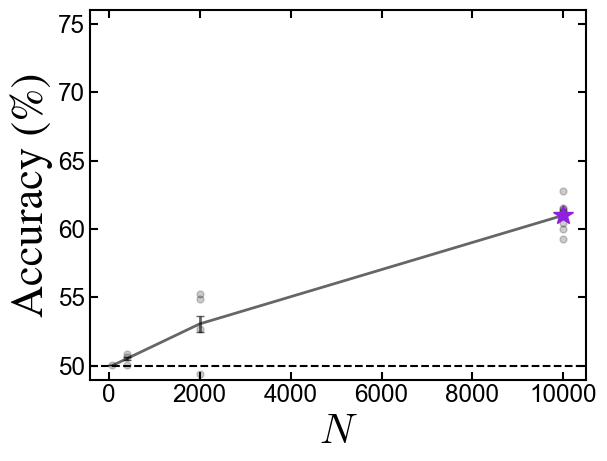

In [6]:
fig, ax = plt.subplots(1,1)
hyp_study_param(ax, 'N', [80, 400, 2000, 10000], 10000, first=True)

# plt.savefig('fig_sup_D_set.png', dpi=300)

c:\Users\hyeji\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
C:\Users\hyeji\AppData\Local\Temp\ipykernel_13020\2833938214.py:25: RuntimeWarning: All-NaN slice encountered
  ax[1].fill_between(np.arange(ac_curve.shape[1]), np.nanmin(ac_curve, axis=0), np.nanmax(ac_curve, axis=0), \


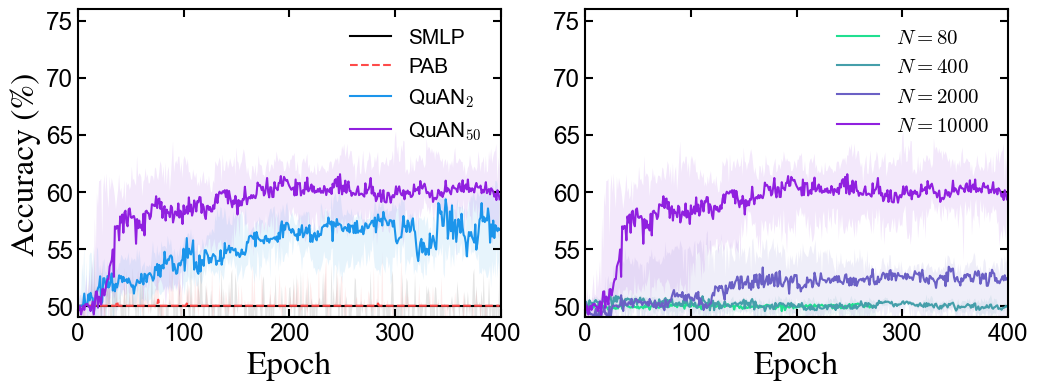

In [10]:
modeldict = {'cm1':r'QuAN$_{50}$', 'c11':r'QuAN$_2$', 'c01':'PAB', 'c00':'SMLP'}

nsy = '0'
nr,nc,d1 = 5,5,8
ms = 5
n = 10

fig, ax = plt.subplots(1,2, figsize=(12, 4))
mn = 'cm1'
color_r = ['#20DF90', '#459FAA', '#6B60C5', '#9020DF']
for k,setsize in enumerate([80,400,2000,10000]):
    ac_curve = np.zeros((8, 400)); ac_curve[:] = np.nan
    for run in np.arange(ac_curve.shape[0]):
        filename = 'Data_out/g2_saved_models_rqc/'+\
                    f'{mn}_A2_p{nsy[0]}_{nr}x{nc}_{d1}_vs20_run_{run}/'+\
                    f'log_{nr}x{nc}_F_p{nsy[0]}_{d1}vs20-{mn}_set{setsize}_h16nh4_ch16ker2st1_#miniset{ms}.txt'
        if not is_non_zero_file(filename, False, filelen=20): continue
        _,_,_,_,ac_vl,ac_ts,_,_,_,_ = np.loadtxt(filename, dtype='float64', unpack=True)
        ac_vl, ac_ts = ac_vl[:400]*100, ac_ts[:400]*100
        ac_ts_max = ac_ts[np.argsort(near(ac_vl,n=n))[-1]:np.argsort(near(ac_vl,n=n))[-1]+n].mean()
        ac_vl_max = ac_vl[np.argsort(near(ac_ts,n=n))[-1]:np.argsort(near(ac_ts,n=n))[-1]+n].mean()
        if ac_ts_max > ac_vl_max: ac_curve[run, :len(ac_ts)] = ac_ts
        else: ac_curve[run, :len(ac_vl)] = ac_vl
    ax[1].plot(np.nanmedian(ac_curve, axis=0), c=color_r[k], label=fr'$N={setsize}$')
    ax[1].fill_between(np.arange(ac_curve.shape[1]), np.nanmin(ac_curve, axis=0), np.nanmax(ac_curve, axis=0), \
                     color=color_r[k], alpha=.1, ec='none')


color_r = ['#9020DF', '#1c95eb', '#FE4A49', 'k'][::-1]
for k, mn in enumerate(['c00', 'c01', 'c11', 'cm1']):
    ac_curve = np.zeros((8, 400)); ac_curve[:] = np.nan
    for run in np.arange(ac_curve.shape[0]):
        filename = 'Data_out/g2_saved_models_rqc/'+\
                    f'{mn}_A2_p{nsy[0]}_{nr}x{nc}_{d1}_vs20_run_{run}/'+\
                    f'log_{nr}x{nc}_F_p{nsy[0]}_{d1}vs20-{mn}_set{setsize}_h16nh4_ch16ker2st1_#miniset{ms}.txt'
        if not is_non_zero_file(filename, False, filelen=20): continue
        _,_,_,_,ac_vl,ac_ts,_,_,_,_ = np.loadtxt(filename, dtype='float64', unpack=True)
        ac_vl, ac_ts = ac_vl[:400]*100, ac_ts[:400]*100
        ac_ts_max = ac_ts[np.argsort(near(ac_vl,n=n))[-1]:np.argsort(near(ac_vl,n=n))[-1]+n].mean()
        ac_vl_max = ac_vl[np.argsort(near(ac_ts,n=n))[-1]:np.argsort(near(ac_ts,n=n))[-1]+n].mean()
        if ac_ts_max > ac_vl_max: ac_curve[run, :len(ac_ts)] = ac_ts
        else: ac_curve[run, :len(ac_vl)] = ac_vl
    if mn != 'c01':
        ax[0].plot(np.nanmedian(ac_curve, axis=0), c=color_r[k], label=f'{modeldict[mn]}')
    else:
        ax[0].plot(np.nanmedian(ac_curve, axis=0), '--', c=color_r[k], label=f'{modeldict[mn]}')
        
    ax[0].fill_between(np.arange(ac_curve.shape[1]), np.nanmin(ac_curve, axis=0), np.nanmax(ac_curve, axis=0), \
                     color=color_r[k], alpha=.1, ec='none')

    for a in ax:
        a.set_xlim(0, 400)
        a.set_ylim(49, 76)
        a.set_xlabel('Epoch', fontsize=24, font='STIXGeneral')

ax[0].set_ylabel('Accuracy (%)', fontsize=24, font='STIXGeneral')
ax[1].legend(ncol=1,fontsize=15)
ax[0].legend(fontsize=15)
# plt.savefig('fig_sup_D_curve.png', dpi=300)

x00 49.499 +- 0.509 [49.000 50.693 50.360 49.600 47.840]
c3d 49.856 +- 0.845 [49.707 46.920 50.920 49.760 51.973]
tre 50.000 +- 0.000 [50.000 50.000 50.000 50.000 50.000]
c00 50.301 +- 0.243 [50.253 50.000 50.000 50.000 51.253]
c01 50.784 +- 0.146 [51.080 50.507 50.973 50.360 51.000]
c11 56.429 +- 0.402 [55.783 57.240 55.227 57.240 56.653]
cm1 61.164 +- 0.559 [60.956 59.933 61.222 60.489 63.222]


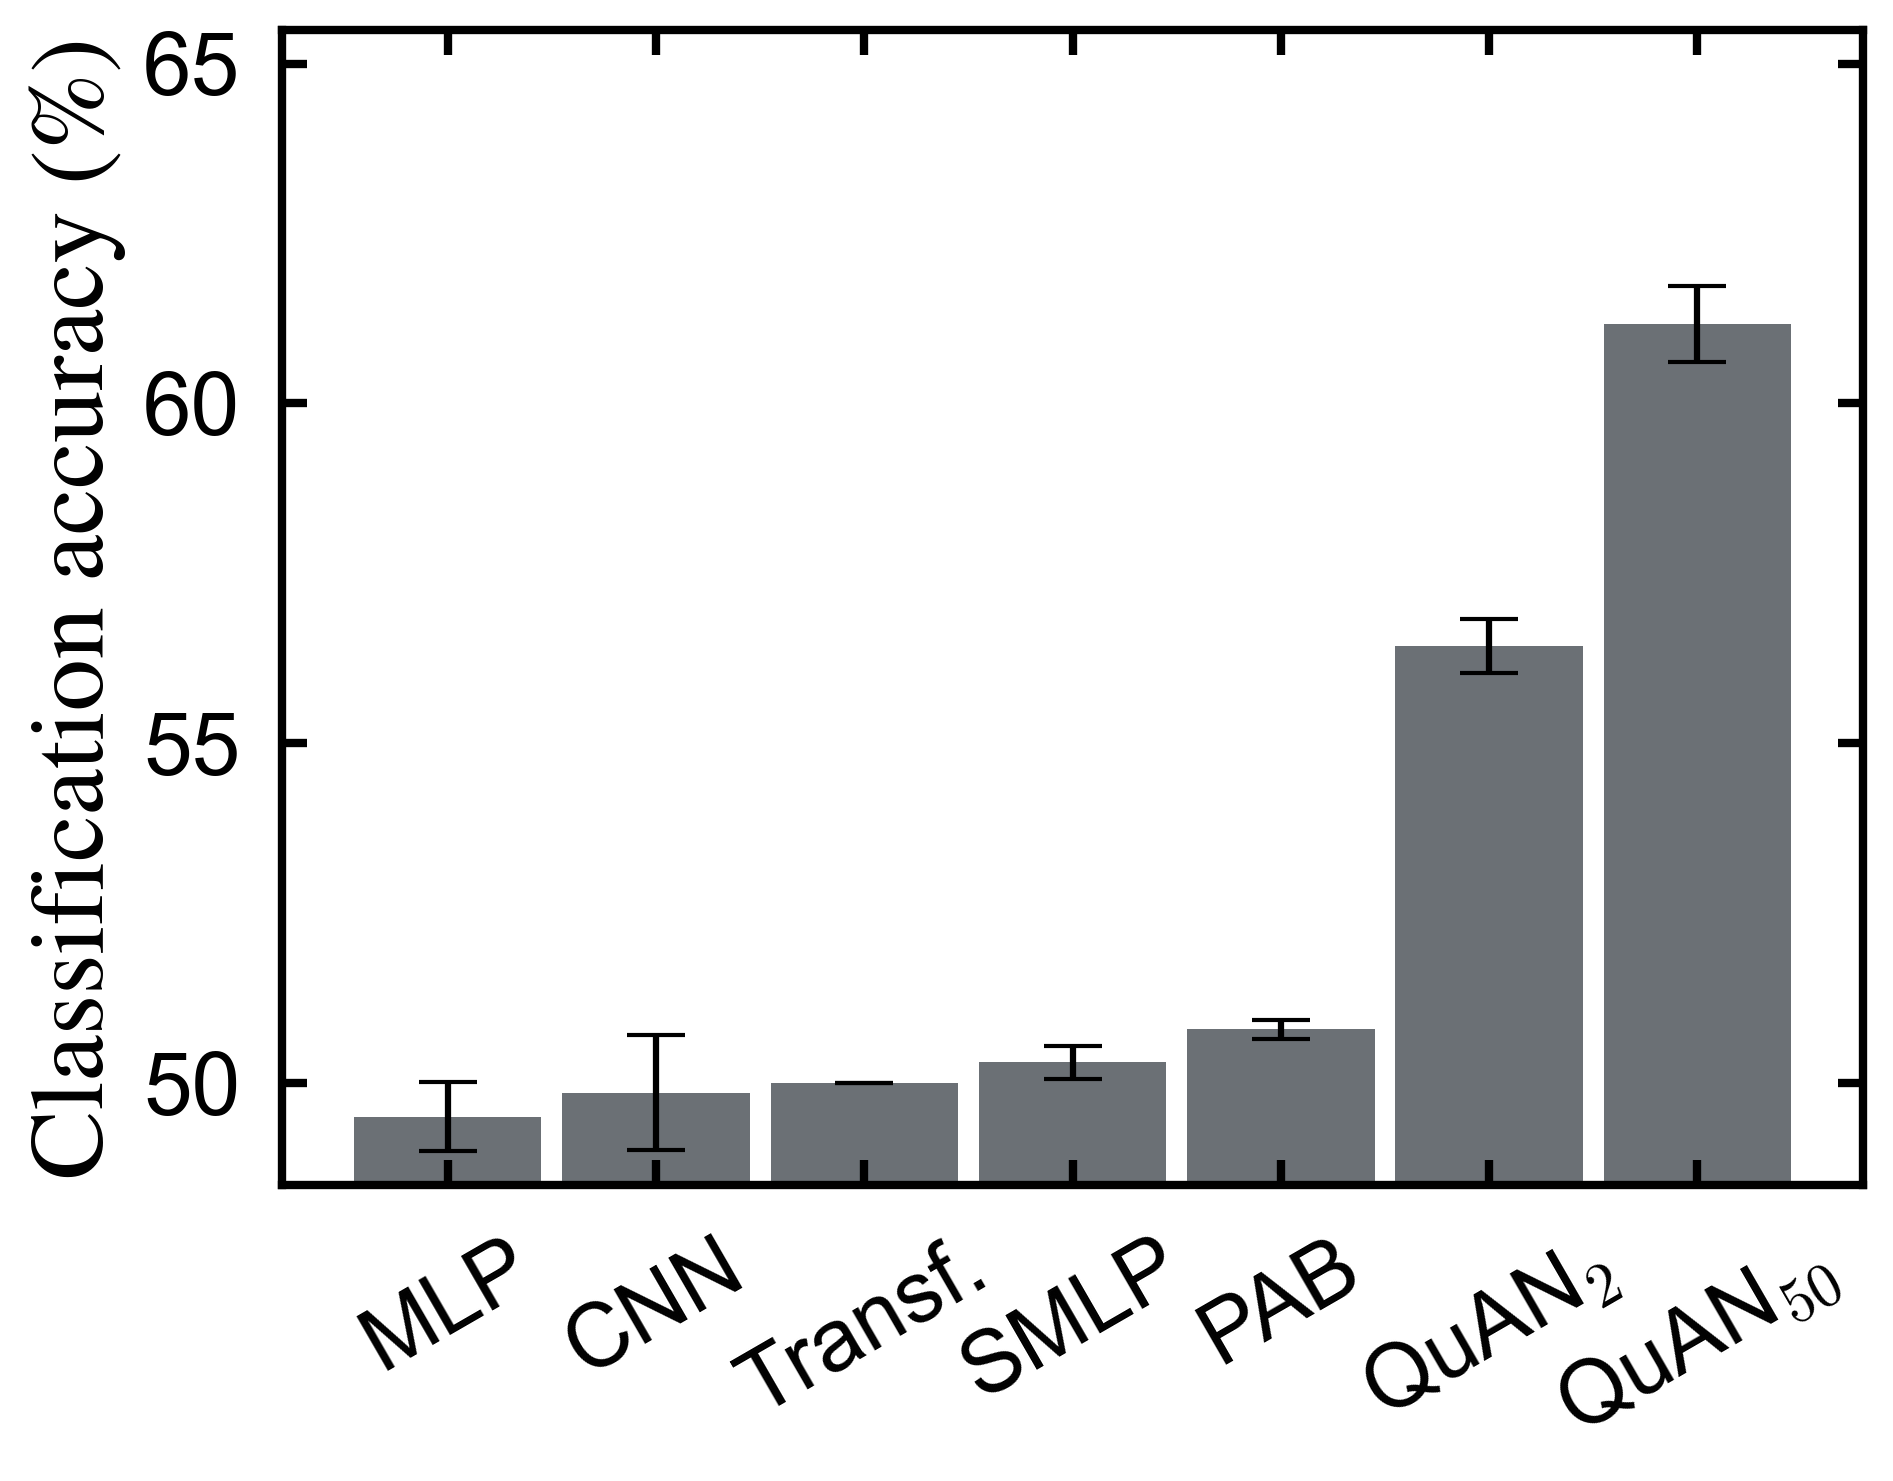

In [17]:
mpl.rcParams['axes.linewidth'] = 2
modelnum_dict = {'x00':0, 'c3d':1, 'tre':2, 'c00':3,'c01':4,'c11':5,'cm1':-1}
d1 = 8
nr = 5
nc = nr
nsy = '0'
clr = sns.color_palette()
accuracies = np.ones(7)*50; accuracies[-2] = 0
accuracies_err = np.zeros(7) 

modelname = ['x00', 'c3d', 'tre', 'c00', 'c01', 'c11', 'cm1']
for i, mn in enumerate(modelname):
    setsize = 10000; ms = 5
    run_avg = []
    for run in np.arange(5):
        filename = 'Data_out/g2_saved_models_rqc/'+\
                    f'{mn}_A2_p{nsy[0]}_{nr}x{nc}_{d1}_vs20_run_{run}/'+\
                    f'log_{nr}x{nc}_F_p{nsy[0]}_{d1}vs20-{mn}_set{setsize}_h16nh4_ch16ker2st1_#miniset{ms}.txt'
        if not is_non_zero_file(filename, False, filelen=20): continue
        truncate, n = 800, 3
        if mn!='cm1': truncate, n = 400, 5
        _,_,_,_,ac_vl,ac_ts,_,_,_,_ = np.loadtxt(filename, dtype='float64', unpack=True, max_rows=truncate)
        if len(_)>25: ac_vl, ac_ts = ac_vl[15:], ac_ts[15:]
        ac_ts_max = ac_ts[np.argsort(near(ac_vl,n=n))[-1]:np.argsort(near(ac_vl,n=n))[-1]+n].mean()
        ac_vl_max = ac_vl[np.argsort(near(ac_ts,n=n))[-1]:np.argsort(near(ac_ts,n=n))[-1]+n].mean()
        if np.argsort(near(ac_vl,n=n))[-1] > np.argsort(near(ac_ts,n=n))[-1]: run_avg.append(ac_ts_max)
        else: run_avg.append(ac_vl_max)


    if len(run_avg)==0: run_avg = [0.5]

    with np.printoptions(formatter={'float': '{:.3f}'.format}):
        print(mn, f'{np.array(run_avg).mean()*100:.3f} +- {np.array(run_avg).std()*100/2:.3f}', \
              np.array(run_avg)*100)
    accuracies[modelnum_dict[mn]] = np.array(run_avg).mean()*100
    accuracies_err[modelnum_dict[mn]] = np.array(run_avg).std()*100/2
plt.show()

modelnames = ['MLP', 'CNN', \
              'Transf.', \
              'SMLP', 'PAB', r'QuAN$_{2}$',\
              r'QuAN$_{50}$']

plt.figure(figsize=(6.8, 5.0), dpi=300)

barlist = plt.bar(modelnames, accuracies, width=0.9, color='#6B7075')
plt.errorbar(modelnames, accuracies, yerr=accuracies_err, fmt='.', ms=0, c='k', capsize=7)
plt.ylim(48.5,65.5)
for tick in plt.gca().get_xticklabels():
    tick.set_rotation(30)
plt.ylabel(fr'Classification accuracy (%)', fontsize=25, font='STIXGeneral')
plt.gca().tick_params(axis='x', which='major', pad=10, labelsize=21)
plt.gca().tick_params(axis='y', which='major', pad=10, labelsize=21)
plt.gca().xaxis.set_tick_params(width=2)
plt.gca().yaxis.set_tick_params(width=2)
# plt.savefig('fig3c.png', dpi = 400)

In [5]:
size_color = ['#BD4032', '#D3770D', '#15A2A0', '#1879BF'][::-1]
size_color = ['#006493', '#9763ad', '#f15f75', '#e79d14', '#32a852']

size_format = ['^-', 's-', 'D-', 'o-', 'X-']
size_ms = [10,8,8,10,12]

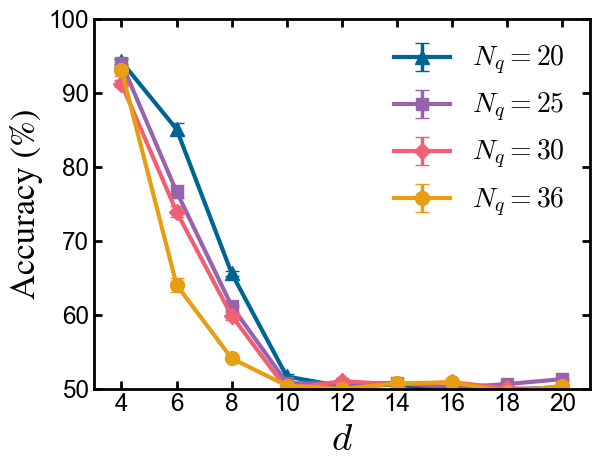

In [21]:
mpl.rcParams['axes.linewidth'] = 2

n =10
nsy = '0'
color = sns.color_palette()
setsize = 10000

for k, nr, nc in ([(0,4,5), (1,5,5), (2,5,6), (3,6,6)]):
    y, yerr = np.zeros(9), np.ones(9)*0.5
    for j, d1 in enumerate(np.array([4,6,8,10,12,14,16,18,20])):
        truncate = 2000
        maxacc = 0
        run_avg = []
        run_avg_ = []
        for run in np.arange(10):
            filename = 'Data_out/g2_saved_models_rqc/'+\
                f'cm1_A2_p0_{nr}x{nc}_{d1}_vs20_run_{run}/'+\
                f'log_{nr}x{nc}_F_p0_{d1}vs20-cm1_set{setsize}_h16nh4_ch16ker2st1_#miniset5.txt'
            if not is_non_zero_file(filename, False, filelen = 20): continue

            _,_,_,_,ac_vl,ac_ts,_,_,_,_ = np.loadtxt(filename, dtype='float64', unpack=True)
            if nr == 6: n = 1
            else: 
                n = 5
                if len(_)>25: ac_vl, ac_ts = ac_vl[15:], ac_ts[15:]
                else: continue
            ac_ts_max = ac_ts[np.argsort(near(ac_vl,n=n))[-1]:np.argsort(near(ac_vl,n=n))[-1]+n].mean()
            ac_vl_max = ac_vl[np.argsort(near(ac_ts,n=n))[-1]:np.argsort(near(ac_ts,n=n))[-1]+n].mean()
            if ac_ts_max > ac_vl_max: run_avg.append(ac_ts_max)
            else: run_avg.append(ac_vl_max)

        y[j] = np.mean(run_avg)
        yerr[j] = np.std(run_avg)/np.sqrt(len(run_avg)-1)
    plt.errorbar(np.array([4,6,8,10,12,14,16,18,20]), y*100, yerr=yerr*100/2, c=size_color[k], \
                 capsize=5, lw=3, elinewidth=2.5, ms=size_ms[k], fmt=size_format[k], label=fr'$N_q={nr*nc}$')
    plt.ylim(50,100)
    plt.xlim(3, 21)
    plt.xlabel(r'$d$', fontsize=28)
    plt.ylabel(r'Accuracy (%)', fontsize=25, font='STIXGeneral')
    plt.gca().set_xticks([4,6,8,10,12,14,16,18,20])
    plt.gca().xaxis.set_tick_params(width=2)
    plt.gca().yaxis.set_tick_params(width=2)
    plt.legend(fontsize=20, loc=1)
# plt.savefig('fig3e.png', dpi = 300)

4x5  8vs20: 65.587 +- 0.947 [64.827 69.747 66.320 64.680 66.000 63.067 63.947 66.107]
5x5  8vs20: 61.167 +- 0.464 [61.307 60.440 61.280 61.533 62.760 61.267 59.280 61.467]
5x6  8vs20: 59.848 +- 1.423 [57.453 59.333 60.560 59.453 66.733 60.160 57.427 57.667]
6x6  8vs20: 54.079 +- 0.520 [53.000 53.500 54.000 56.233 53.567 53.000 55.100 54.233]
---------------------------
4x5  8vs20: 66.404 +- 1.245 [62.933 70.167 65.693 65.167 68.060]
5x5  8vs20: 60.840 +- 1.094 [57.147 60.080 61.787 63.753 61.433]
5x6  8vs20: 59.440 +- 1.238 [60.633 62.840 55.953 57.320 60.453]
6x6  8vs20: 54.060 +- 0.566 [53.000 53.500 54.000 56.233 53.567]
---------------------------


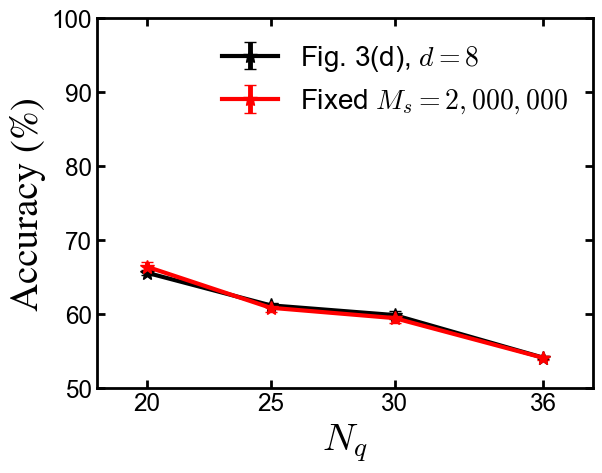

In [25]:

mpl.rcParams['axes.linewidth'] = 2

n =10
nsy = '0'
color = sns.color_palette()
setsize = 10000

for j, d1 in enumerate(np.array([4,6,8,10,12,14,16,18,20])):
    if d1 not in [8]: continue
    y, yerr = np.zeros(4), np.ones(4)*0.5
    for k, nr, nc in ([(0,4,5), (1,5,5), (2,5,6), (3,6,6)]):
        truncate = 200; maxacc = 0; run_avg = []; run_avg_ = []
        for run in np.arange(10):
            if nr==6 or d1!=8:
                filename = 'Data_out/g2_saved_models_rqc/'+\
                f'cm1_A2_p0_{nr}x{nc}_{d1}_vs20_run_{run}/'+\
                f'log_{nr}x{nc}_F_p0_{d1}vs20-cm1_set{setsize}_h16nh4_ch16ker2st1_#miniset5.txt'
            else:
                filename = 'Data_out/g2_saved_models_rqc/'+\
                f'cm1_A2_p0_{nr}x{nc}_{d1}_vs20_run_{run}/'+\
                f'log_{nr}x{nc}_F_p0_{d1}vs20-cm1_set{setsize}_h16nh4_ch16ker2st1_#miniset5.txt'
            if not is_non_zero_file(filename, False, filelen = 20): continue

            _,_,_,_,ac_vl,ac_ts,_,_,_,_ = np.loadtxt(filename, dtype='float64', unpack=True)
            if nr == 6: n = 1
            else: 
                n = 5
                if len(_)>25: ac_vl, ac_ts = ac_vl[15:], ac_ts[15:]
                else: continue
            ac_ts_max = ac_ts[np.argsort(near(ac_vl,n=n))[-1]:np.argsort(near(ac_vl,n=n))[-1]+n].mean()
            ac_vl_max = ac_vl[np.argsort(near(ac_ts,n=n))[-1]:np.argsort(near(ac_ts,n=n))[-1]+n].mean()
            if ac_ts_max > ac_vl_max: run_avg.append(ac_ts_max)
            else: run_avg.append(ac_vl_max)

        y[k] = np.mean(run_avg)
        yerr[k] = np.std(run_avg)/np.sqrt(len(run_avg)-1)
        with np.printoptions(formatter={'float': '{:.3f}'.format}):
            print(f'{nr}x{nc}', \
                  f'{d1:2d}vs20: {np.array(run_avg).mean()*100:.3f} +- {np.array(run_avg).std()*100/2:.3f}', \
              np.array(run_avg)*100)
    print('---------------------------')
    plt.errorbar(np.array([20, 25, 30, 36]), y*100, yerr=yerr*100/2, c='k', \
                 capsize=4, lw=3, elinewidth=3.5, ms=10, fmt='*-', label=fr'Fig. 3(d), $d=8$')


for j, d1 in enumerate(np.array([4,6,8,10,12,14,16,18,20])):
    if d1 not in [8]: continue
    y, yerr = np.zeros(4), np.ones(4)*0.5
    for k, nr, nc in ([(0,4,5), (1,5,5), (2,5,6), (3,6,6)]):
        truncate = 200; maxacc = 0; run_avg = []; run_avg_ = []
        for run in np.arange(5):
            if nr==6 or d1!=8:
                filename = 'Data_out/g2_saved_models_rqc/'+\
                f'cm1_A2_p0_{nr}x{nc}_{d1}_vs20_run_{run}/'+\
                f'log_{nr}x{nc}_F_p0_{d1}vs20-cm1_set{setsize}_h16nh4_ch16ker2st1_#miniset5.txt'
            else:
                filename = 'Data_out/g2_saved_models_rqc/'+\
                f'cm1_A2_x4_p0_{nr}x{nc}_{d1}_vs20_run_{run}/'+\
                f'log_{nr}x{nc}_F_p0_{d1}vs20-cm1_set{setsize}_h16nh4_ch16ker2st1_#miniset5.txt'
            if not is_non_zero_file(filename, False, filelen = 20): continue

            _,_,_,_,ac_vl,ac_ts,_,_,_,_ = np.loadtxt(filename, dtype='float64', unpack=True)
            if nr == 6: n = 1
            else: 
                n = 5
                if len(_)>25: ac_vl, ac_ts = ac_vl[15:], ac_ts[15:]
                else: continue
            ac_ts_max = ac_ts[np.argsort(near(ac_vl,n=n))[-1]:np.argsort(near(ac_vl,n=n))[-1]+n].mean()
            ac_vl_max = ac_vl[np.argsort(near(ac_ts,n=n))[-1]:np.argsort(near(ac_ts,n=n))[-1]+n].mean()
            if ac_ts_max > ac_vl_max: run_avg.append(ac_ts_max)
            else: run_avg.append(ac_vl_max)

        y[k] = np.mean(run_avg)
        yerr[k] = np.std(run_avg)/np.sqrt(len(run_avg)-1)
        with np.printoptions(formatter={'float': '{:.3f}'.format}):
            print(f'{nr}x{nc}', \
                  f'{d1:2d}vs20: {np.array(run_avg).mean()*100:.3f} +- {np.array(run_avg).std()*100/2:.3f}', \
              np.array(run_avg)*100)
    print('---------------------------')
    plt.errorbar(np.array([20, 25, 30, 36]), y*100, yerr=yerr*100/2, c='r', \
                 capsize=4, lw=3, elinewidth=3.5, ms=10, fmt='*-', label=fr'Fixed $M_s=2,000,000$')
    plt.ylim(50,100)
    plt.xlim(18, 38)
    plt.xlabel(r'$N_q$', fontsize=28)
    plt.ylabel(r'Accuracy (%)', fontsize=28, font='STIXGeneral')
    plt.gca().set_xticks([20, 25, 30, 36])
    plt.gca().xaxis.set_tick_params(width=2)
    plt.gca().yaxis.set_tick_params(width=2)
    plt.legend(fontsize=20, loc=1)
# plt.savefig('scale.pdf', format='pdf', dpi = 300)

In [139]:
prefix = 'Data_out/g2_saved_models_rqc/'
nsy_kind = ['0', 'google']

accarray = np.zeros((4,2,2,9,9,8)); accarray[:] = np.nan
accarray0 = np.zeros((4,2,2,9,9,8)); accarray0[:] = np.nan
accarray1 = np.zeros((4,2,2,9,9,8)); accarray1[:] = np.nan
for n, nr, nc in [(0,4,5), (1,5,5), (2,5,6), (3,6,6)]:
    for j,nsymodel in enumerate(['0', 'google']):
        for k,nsydata in enumerate(['0', 'google']):
            for l,d1model in enumerate(np.arange(2,11)*2):
                for m,d1data in enumerate(np.arange(2,11)*2):
                    for run in [0,1,2,3,4,5,6,7]:
                        acc_va, acc_ta = 0, 0; acc_va0, acc_ta0 = np.nan, np.nan; acc_va1, acc_ta1 = np.nan, np.nan
                        acc_vl, acc_tl = 0, 0; acc_vl0, acc_tl0 = np.nan, np.nan; acc_vl1, acc_tl1 = np.nan, np.nan
                        folder = f'cm1_A2_p{nsymodel[0]}_{nr}x{nc}_{d1model}_vs20_run_{run}/'
                        file_m = f'{nr}x{nc}_F_p{nsymodel}_{d1model}vs20-cm1_set10000_h16nh4_ch16ker2st1_#miniset5.txt'
                        
                        file_d = f'test_acc-data_p{nsydata}_{d1data}vs20-model_va_'
                        filename = f'{prefix}{folder}{file_d}{file_m}'
                        acc_va = loadtxt(filename)[0]
                        if not np.isnan(acc_va):
                            acc_va0 = loadtxt(filename)[1]
                            acc_va1 = loadtxt(filename)[2]
                        file_d = f'test_acc-data_p{nsydata}_{d1data}vs20-model_ta_'
                        filename = f'{prefix}{folder}{file_d}{file_m}'
                        acc_ta = loadtxt(filename)[0]
                        if not np.isnan(acc_ta):
                            acc_ta0 = loadtxt(filename)[1]
                            acc_ta1 = loadtxt(filename)[2]
                        file_d = f'test_acc-data_p{nsydata}_{d1data}vs20-model_vl_'
                        filename = f'{prefix}{folder}{file_d}{file_m}'
                        acc_vl = loadtxt(filename)[0]
                        if not np.isnan(acc_vl):
                            acc_vl0 = loadtxt(filename)[1]
                            acc_vl1 = loadtxt(filename)[2]
                        file_d = f'test_acc-data_p{nsydata}_{d1data}vs20-model_tl_'
                        filename = f'{prefix}{folder}{file_d}{file_m}'
                        acc_tl = loadtxt(filename)[0]
                        if not np.isnan(acc_tl):
                            acc_tl0 = loadtxt(filename)[1]
                            acc_tl1 = loadtxt(filename)[2]

                        accarray[n,j,k,l,m,run] = np.nanmax([acc_va, acc_ta, acc_vl, acc_tl])
                        if np.isnan(np.nanmax([acc_va, acc_ta, acc_vl, acc_tl])): continue
                        accarray0[n,j,k,l,m,run] = [acc_va0, acc_ta0, acc_vl0, acc_tl0][np.nanargmax([acc_va, acc_ta, acc_vl, acc_tl])]
                        accarray1[n,j,k,l,m,run] = [acc_va1, acc_ta1, acc_vl1, acc_tl1][np.nanargmax([acc_va, acc_ta, acc_vl, acc_tl])]


/var/folders/km/qpx_vm0n53z_pvldds5qm8pw0000gn/T/ipykernel_14378/2877501953.py:43: RuntimeWarning: All-NaN axis encountered
  accarray[n,j,k,l,m,run] = np.nanmax([acc_va, acc_ta, acc_vl, acc_tl])
/var/folders/km/qpx_vm0n53z_pvldds5qm8pw0000gn/T/ipykernel_14378/2877501953.py:44: RuntimeWarning: All-NaN axis encountered
  if np.isnan(np.nanmax([acc_va, acc_ta, acc_vl, acc_tl])): continue


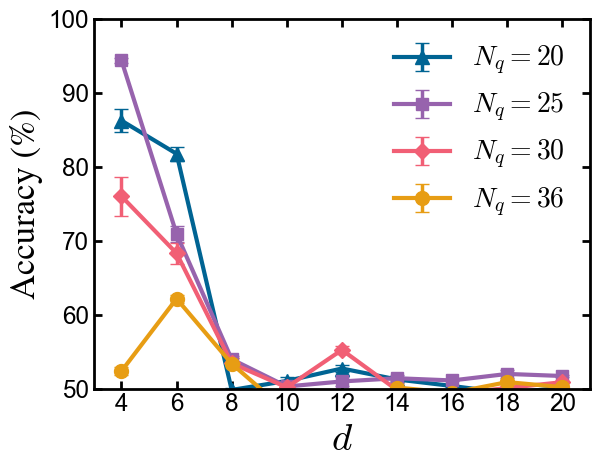

In [176]:
for k, nr, nc in [(0,4,5), (1,5,5), (2,5,6), (3,6,6)]:
    y = np.diag(np.nanmean(accarray[k,0,1], axis=-1))
    yerr = np.diag(np.nanstd(accarray[k,0,1], axis=-1)/np.sqrt(np.sum(~np.isnan(accarray[k,0,1]), axis=-1)))
    plt.errorbar(np.array([4,6,8,10,12,14,16,18,20]), y*100, yerr=yerr*100/2, c=size_color[k], \
                capsize=5, lw=3, elinewidth=2.5, ms=size_ms[k], fmt=size_format[k], label=fr'$N_q={nr*nc}$')
plt.ylim(50, 100)
plt.xlim(3, 21)
plt.xlabel(r'$d$', fontsize=28)
plt.ylabel(r'Accuracy (%)', fontsize=25, font='STIXGeneral')
plt.legend(fontsize=20, loc=1)
plt.gca().set_xticks([4,6,8,10,12,14,16,18,20])
plt.gca().xaxis.set_tick_params(width=2)
plt.gca().yaxis.set_tick_params(width=2)
# plt.savefig('fig3g.png', dpi = 300)

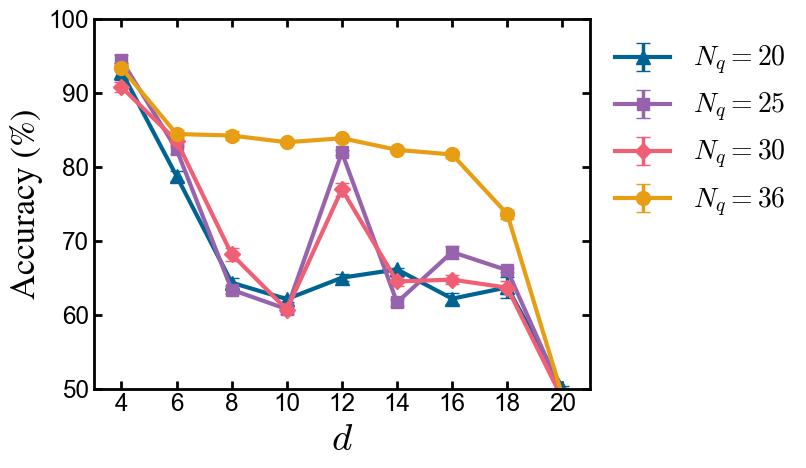

In [18]:
mpl.rcParams['axes.linewidth'] = 2

n =10
nsy = '0'
color = sns.color_palette()
setsize = 10000

for k, nr, nc in ([(0,4,5), (1,5,5), (2,5,6), (3,6,6)]):
    y, yerr = np.zeros(9), np.ones(9)*0.5
    for j, d1 in enumerate(np.array([4,6,8,10,12,14,16,18,20])):
        truncate = 200
        maxacc = 0
        run_avg = []
        run_avg_ = []
        run_len = []
        for run in np.arange(10):
            filename = 'Data_out/g2_saved_models_rqc/'+\
                f'cm1_A2_pg_{nr}x{nc}_{d1}_vs20_run_{run}/'+\
                f'log_{nr}x{nc}_F_pgoogle_{d1}vs20-cm1_set{setsize}_h16nh4_ch16ker2st1_#miniset5.txt'
            if not is_non_zero_file(filename, False, filelen = 5): continue

            _,_,_,_,ac_vl,ac_ts,_,_,_,_ = np.loadtxt(filename, dtype='float64', unpack=True, max_rows=truncate)
            if nr == 6: n = 5
            else: n = 5
            ac_ts_max = ac_ts[np.argsort(near(ac_vl,n=n))[-1]:np.argsort(near(ac_vl,n=n))[-1]+n].mean()
            ac_vl_max = ac_vl[np.argsort(near(ac_ts,n=n))[-1]:np.argsort(near(ac_ts,n=n))[-1]+n].mean()
            if ac_ts_max > ac_vl_max: run_avg.append(ac_vl_max)
            else: run_avg.append(ac_ts_max)
            run_len.append(len(ac_vl))

        y[j] = np.mean(run_avg)
        yerr[j] = np.std(run_avg)/np.sqrt(len(run_avg)-1)
    plt.errorbar(np.array([4,6,8,10,12,14,16,18,20]), y*100, yerr=yerr*100/2, c=size_color[k], \
                 capsize=5, lw=3, elinewidth=2.5, ms=size_ms[k], fmt=size_format[k], label=fr'$N_q={nr*nc}$')
    plt.ylim(50,100)
    plt.xlim(3, 21)
    plt.xlabel(r'$d$', fontsize=28)
    plt.ylabel(r'Accuracy (%)', fontsize=25, font='STIXGeneral')
    plt.gca().set_xticks([4,6,8,10,12,14,16,18,20])
    plt.gca().xaxis.set_tick_params(width=2)
    plt.gca().yaxis.set_tick_params(width=2)
    plt.legend(bbox_to_anchor=(1,1), fontsize=20)
# plt.savefig('fig_sup_D_.png', dpi = 300)

/var/folders/km/qpx_vm0n53z_pvldds5qm8pw0000gn/T/ipykernel_14378/210938515.py:4: RuntimeWarning: Mean of empty slice
  y = np.nanmean(accarray[n,i//2,i%2], axis=-1)*100


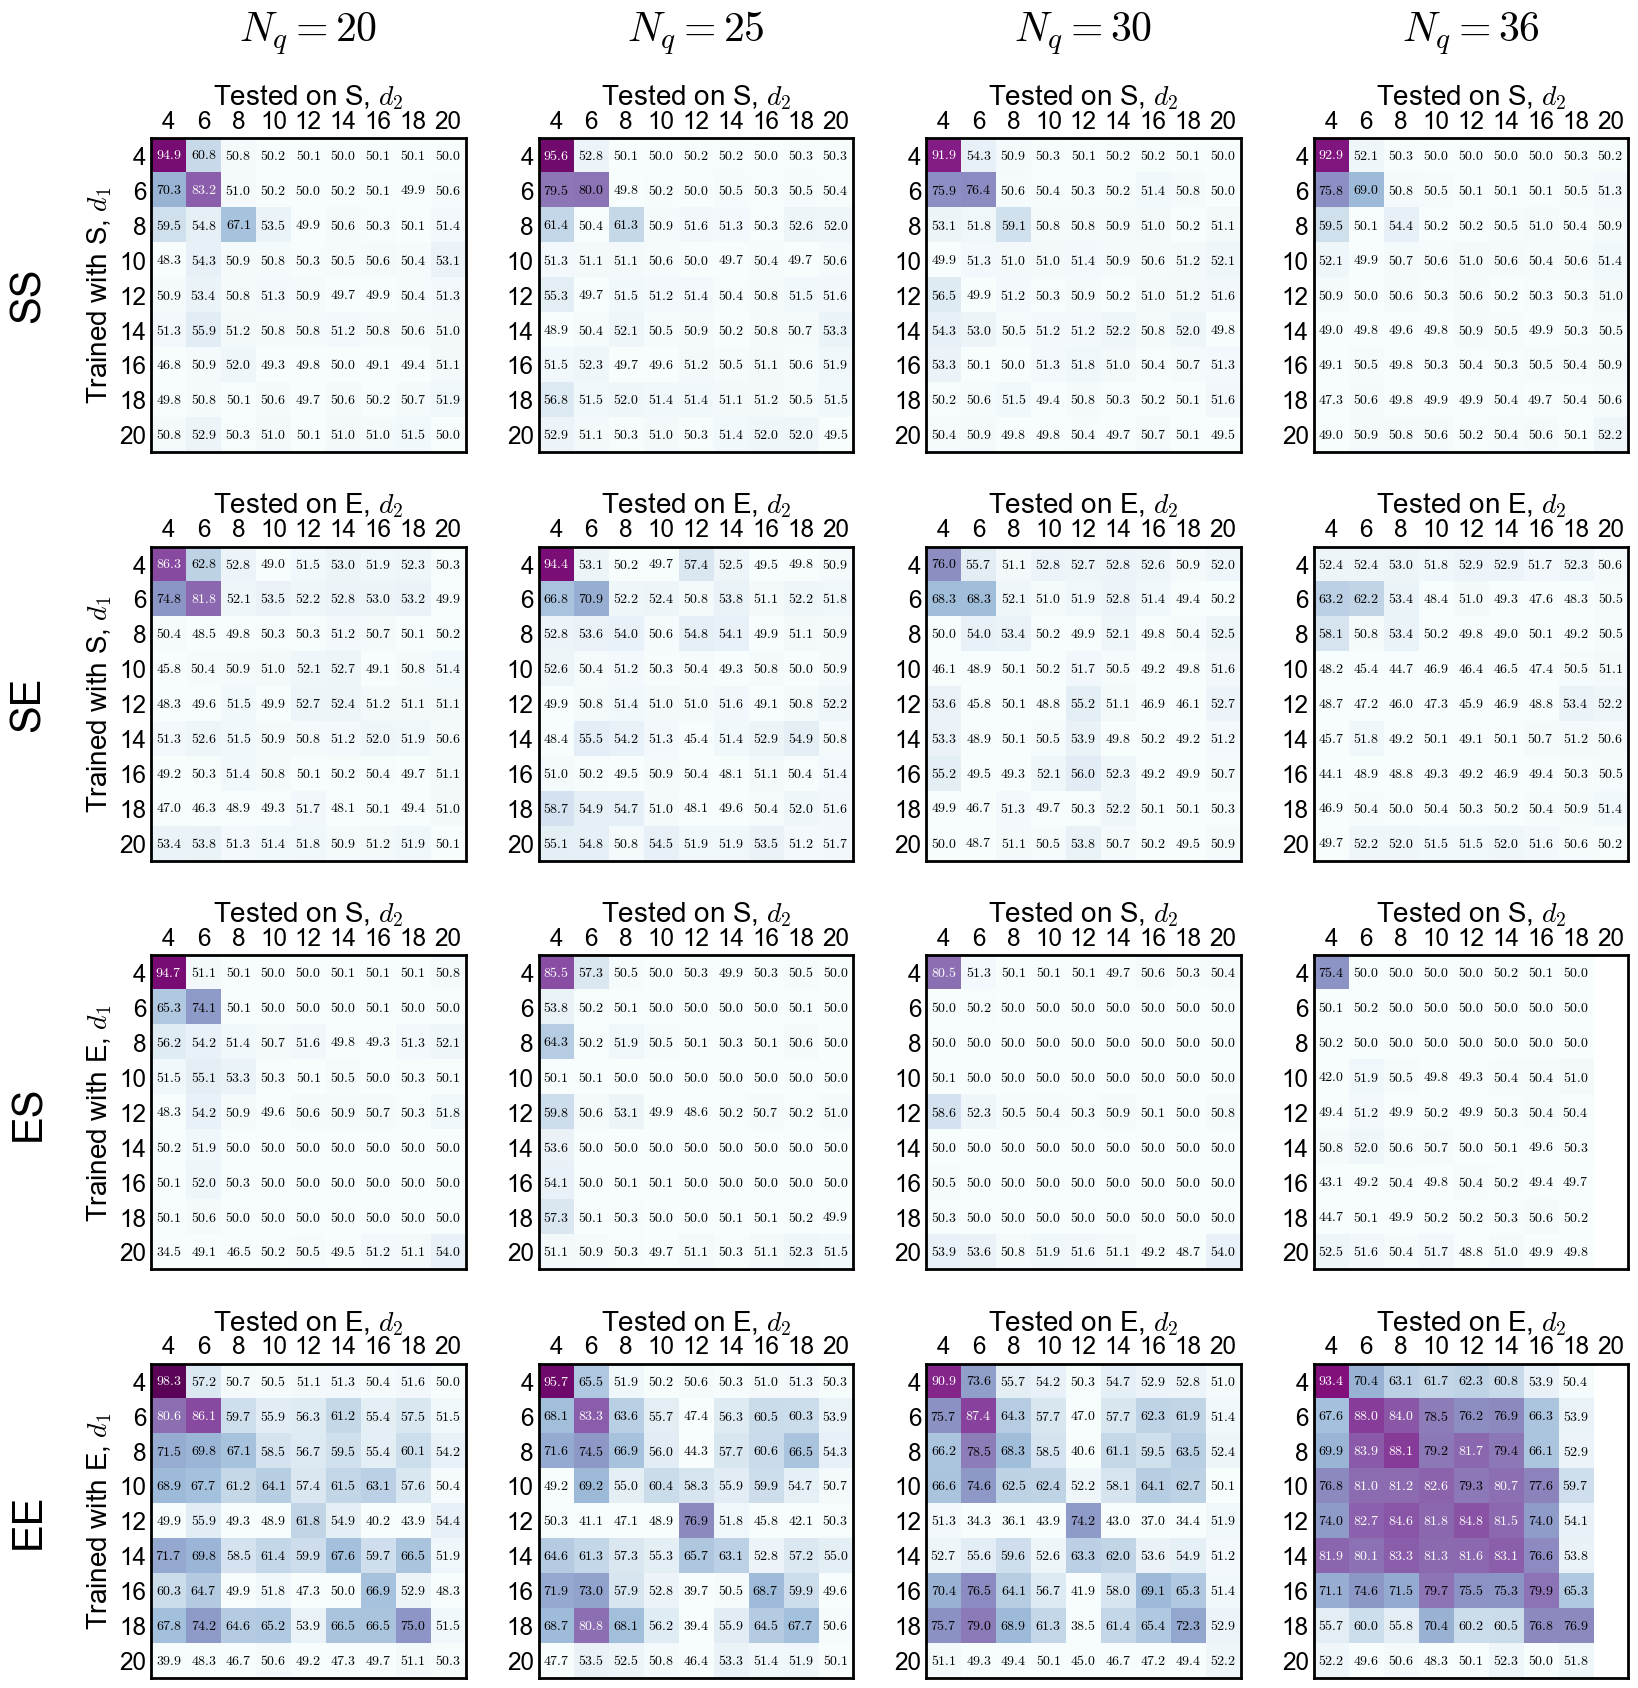

In [166]:
fig, ax = plt.subplots(4,4,figsize=(5*4, 5*4))
for n, nr, nc in [(0,4,5), (1,5,5), (2,5,6), (3,6,6)]:
    for i,a in enumerate(ax[:,n]):
        y = np.nanmean(accarray[n,i//2,i%2], axis=-1)*100
        a.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
        im = a.imshow(y, **{'vmax':1*100, 'vmin':0.5*100}, cmap='BuPu')
        a.set_xticks(np.arange(9))
        a.set_yticks(np.arange(9))
        a.set_xticklabels(np.arange(9)*2+4)
        a.set_yticklabels(np.arange(9)*2+4)
        a.xaxis.set_label_position('top')
        for j in range(9):
            for k in range(9):
                if y[j,k]<80:
                    ax[i,n].text(k,j, fr'${y[j, k]:.1f}$', ha='center', va='center')
                else:
                    ax[i,n].text(k,j, fr'${y[j, k]:.1f}$', ha='center', va='center', color='w')
                
        a.tick_params(axis='x', which='both',   bottom=False, top=False,labelbottom=False)
        a.tick_params(axis='y', which='both',   left=False, right=False,labelbottom=False)
ax[0,0].text(4, -3.5, r'$N_q=20$', ha='center', va='center', fontsize=30)
ax[0,1].text(4, -3.5, r'$N_q=25$', ha='center', va='center', fontsize=30)
ax[0,2].text(4, -3.5, r'$N_q=30$', ha='center', va='center', fontsize=30)
ax[0,3].text(4, -3.5, r'$N_q=36$', ha='center', va='center', fontsize=30)

ax[0,0].set_ylabel(r'Trained with S, $d_1$', fontsize=20)
ax[1,0].set_ylabel(r'Trained with S, $d_1$', fontsize=20)
ax[2,0].set_ylabel(r'Trained with E, $d_1$', fontsize=20)
ax[3,0].set_ylabel(r'Trained with E, $d_1$', fontsize=20)
for i in range(4):
    ax[0,i].set_xlabel(r'Tested on S, $d_2$', fontsize=20); 
    ax[1,i].set_xlabel(r'Tested on E, $d_2$', fontsize=20); 
    ax[2,i].set_xlabel(r'Tested on S, $d_2$', fontsize=20); 
    ax[3,i].set_xlabel(r'Tested on E, $d_2$', fontsize=20); 

ax[0,0].text(-4, 4, r'SS', ha='center', va='center', rotation = 90, fontsize=30)
ax[1,0].text(-4, 4, r'SE', ha='center', va='center', rotation = 90, fontsize=30)
ax[2,0].text(-4, 4, r'ES', ha='center', va='center', rotation = 90, fontsize=30)
ax[3,0].text(-4, 4, r'EE', ha='center', va='center', rotation = 90, fontsize=30)
fig.subplots_adjust(wspace=0, hspace=0.3)
plt.savefig('fig_sup_D_all.png', dpi = 300)

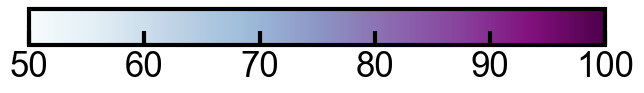

In [192]:
a = np.array([[50,100]])
plt.figure(figsize=(9*4, 1.5*4))
img = plt.imshow(a, cmap="BuPu")
plt.gca().set_visible(False)
cax = plt.axes([0.1, 0.2, 0.8*0.2, 0.3*0.2])
cbar = plt.colorbar(orientation="horizontal", cax=cax)
cbar.ax.tick_params(labelsize=25)
cbar.ax.tick_params(size = 10, width = 3)
cbar.outline.set_linewidth(3)